In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from statannot import add_stat_annotation
from scdna_replication_tools.plot_utils import get_rt_cmap, get_clone_cmap, get_phase_cmap, plot_colorbar, make_color_mat_float, plot_cell_cn_profile2, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and plot the example G1- and S-phase cells from the sorted cell lines

In [3]:
# load in all the input dataframes
cn_t_g1 = pd.read_csv('scdna_replication_paper/analysis/laks_flow/T47D/cn_g1.tsv', sep='\t')
cn_t_s = pd.read_csv('scdna_replication_paper/analysis/laks_flow/T47D/cn_s.tsv', sep='\t')
cn_gm_g1 = pd.read_csv('scdna_replication_paper/analysis/laks_flow/GM18507/cn_g1.tsv', sep='\t')
cn_gm_s = pd.read_csv('scdna_replication_paper/analysis/laks_flow/GM18507/cn_s.tsv', sep='\t')

# convert chr to category type
cn_t_g1['chr'] = cn_t_g1['chr'].astype('category')
cn_t_s['chr'] = cn_t_s['chr'].astype('category')
cn_gm_g1['chr'] = cn_gm_g1['chr'].astype('category')
cn_gm_s['chr'] = cn_gm_s['chr'].astype('category')

# pick which cells to plot for each dataframe
cell_t_g1 = 'SA1044-A96139A-R03-C07'
cell_t_s = 'SA1044-A96139A-R03-C24'
cell_gm_g1 = 'SA928-A73044A-R07-C03'
cell_gm_s = 'SA928-A73044A-R07-C40'

# subset the dataframes to only include the cells we want to plot
cn_t_g1 = cn_t_g1[cn_t_g1['cell_id'] == cell_t_g1]
cn_t_s = cn_t_s[cn_t_s['cell_id'] == cell_t_s]
cn_gm_g1 = cn_gm_g1[cn_gm_g1['cell_id'] == cell_gm_g1]
cn_gm_s = cn_gm_s[cn_gm_s['cell_id'] == cell_gm_s]

In [4]:
def plot_cell_cn_profile_with_density(cell_cn, ax_scatter, ax_hist, pt_size=1, title=None, xlabel='chromosome', ylabel='reads per million'):
    # find the max rpm value rounded to the nearest 100 below the max rpm value
    max_rpm = cell_cn['rpm'].max()
    max_rpm = max_rpm - (max_rpm % 100)
    # reset the y-axis ticks to be all the 100s ranging between the 0 and max rpm values
    yticks = np.arange(0, max_rpm+100, 100)
    ytick_labels = [str(int(a)) for a in yticks]
    ax_scatter.set_yticks(yticks)
    ax_scatter.set_yticklabels(ytick_labels)
    
    # add subplot for cell cn profile
    plot_cell_cn_profile2(ax_scatter, cell_cn, 'rpm', cn_field_name='state', rawy=True, s=pt_size, rasterized=False)
    ax_scatter.set_ylabel(ylabel)
    ax_scatter.set_xlabel(xlabel)

    if title is not None:
        ax_scatter.set_title(title)

    # add subplot for density plot
    sns.kdeplot(data=cell_cn, y='rpm', ax=ax_hist, shade=True, color='k')
    ax_hist.set_yticks([])
    ax_hist.set_xticks([])
    ax_hist.set_ylabel('')
    ax_hist.set_xlabel('')
    # turn off the spines
    for spine in ax_hist.spines.values():
        spine.set_visible(False)
    # set the y-axis limits to be the same as the scatter plot
    ax_hist.set_ylim(ax_scatter.get_ylim())

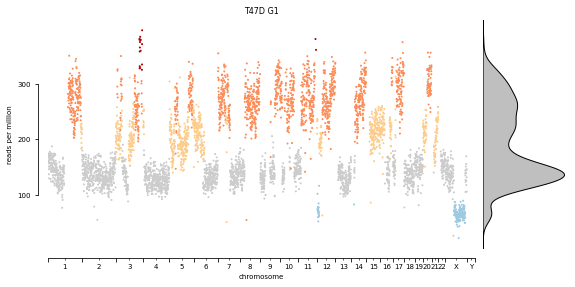

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False, gridspec_kw={'width_ratios': [1, .2]}, tight_layout=True)
for cell_id, cell_cn in cn_t_g1.groupby('cell_id'):
    plot_cell_cn_profile_with_density(cell_cn, axes[0], axes[1], pt_size=1, title='T47D G1', xlabel='chromosome', ylabel='reads per million')
    break
plt.show()

### Load and plot the replication state accuracy comparisons between PERT and Kronos

In [6]:
df_acc = pd.read_csv('scdna_replication_paper/analysis/simulation/all/scRT_accuracies.tsv', sep='\t')
# rename lambda column to avoid conflict with python keyword
df_acc.rename(columns={'lambda': 'lamb'}, inplace=True)
# rename entries that are method=='PERT comp.' to 'PERT'
df_acc.loc[df_acc['method'] == 'PERT comp.', 'method'] = 'PERT'
df_acc.head()

,dataset,datatag,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,rep_accuracy,cn_accuracy
0,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.943182,NaN
1,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997884,0.999987
2,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT,0.997857,0.999991
3,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.934858,NaN
4,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997593,0.999977


In [13]:
def get_methods_cmap():
    cmap = {
        'PERT clone': 'olive',
        'PERT comp.': 'yellowgreen',
        'PERT': 'yellowgreen',
        'Kronos': 'lightcoral',
        'laks': 'darksalmon',
    }
    return cmap


# set the hue order to be the same for all plots
hue_order = ['PERT', 'Kronos']

In [14]:
def violins_with_pvals(df, x, y, hue, ax, box_pairs, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    """ Create a violinplot with p-values annotated. """
    palette = get_methods_cmap()
    sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, palette=palette, linewidth=1, hue_order=hue_order)
    add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                        box_pairs=box_pairs, test=test,
                        text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)


def plot_cna_rate_rep_acc(df, ax, n=1, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replications state accuracy vs cna rate at a fixed number of clones (n). '''
    x = "cell_cna_rate"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('num_clones=={}'.format(n)).query('beta0==1.2')
    box_pairs = [
        ((0.05, "Kronos"), (0.05, "PERT")),
        ((0.02, "Kronos"), (0.02, "PERT")),
        ((0.00, "PERT"), (0.00, "Kronos")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test, text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Sweep across cell CNA rate\n# of clones={}'.format(n))
    ax.set_xlabel('cell CNA rate')
    ax.set_ylabel('replication state accuracy')
    # show the legend in the bottom left corner
    ax.legend(loc='lower left')
    return ax


def plot_clone_effect_rep_acc(df, ax, rate=0.02, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replication accuracy vs number of clones at a fixed cell cna rate. '''
    x = "num_clones"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('cell_cna_rate=={}'.format(rate)).query('num_clones<4').query('beta0==1.2')
    box_pairs = [
        ((3, "Kronos"), (3, "PERT")),
        ((1, "Kronos"), (1, "PERT")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Sweep across # of clones\ncell CNA rate={}'.format(rate))
    ax.set_xlabel('# of clones')
    ax.set_ylabel('replication state accuracy')
    # turn off the legend
    ax.legend().set_visible(False)
    return ax


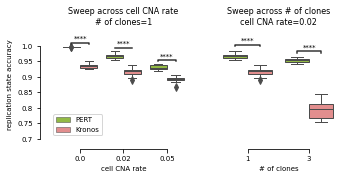

In [15]:
def plot_simulated_rep_accuracies(df_acc, axes):
    '''Plot a sweep across the cell cna rate on the left (n=1) and a sweep across the number of clones on the right (rate=0.02)''' 
    plot_cna_rate_rep_acc(df_acc, axes[0], n=1, hue_order=hue_order, loc='inside')
    plot_clone_effect_rep_acc(df_acc, axes[1], rate=0.02, hue_order=hue_order, loc='inside')

    # reset the y-limits of both subplots to be the max and min of each
    min_ylim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(min_ylim, max_ylim)
    axes[1].set_ylim(min_ylim, max_ylim)

    # remove any ticks or tick-labels that are >1 from both y-axes
    yticks = axes[0].get_yticks()
    yticks = [a for a in yticks if a <= 1]
    yticklabels = [str(a.round(2)) for a in yticks]
    axes[0].set_yticks(yticks)
    axes[0].set_yticklabels(yticklabels)
    axes[1].set_yticks(yticks)
    axes[1].set_yticklabels(yticklabels)

    # despine both the subplots
    sns.despine(ax=axes[0], offset=despine_offset, trim=despine_trim)
    sns.despine(ax=axes[1], offset=despine_offset, trim=despine_trim)

    # hide the y-axis ticks, tick-labels, and spine for the right subplot
    # this needs to be after despining so that the data stays on the same scale as the left subplot
    axes[1].set_yticks([])
    axes[1].set_yticklabels([])
    axes[1].spines['left'].set_visible(False)
    axes[1].set_ylabel('')

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharey=False, tight_layout=True)
plot_simulated_rep_accuracies(df_acc, axes)
plt.show()

### Load and plot the phase accuracy of PERT

In [16]:
df_phase = pd.read_csv('scdna_replication_paper/analysis/simulation/all/phase_accuracies.tsv', sep='\t')

df_phase['PERT_phase'] = df_phase['PERT_phase'].astype(str)
df_phase['true_phase'] = df_phase['true_phase'].astype(str)
df_phase['laks_phase'] = df_phase['laks_phase'].astype(str)
df_phase['cell_id'] = df_phase['cell_id'].astype(str)

# rename the lambda column to lambd to avoid conflict with python keyword
df_phase.rename(columns={'lambda': 'lamb'}, inplace=True)

# melt `PERT_phase_acc` and `laks_phase_acc` into a single column `phase_acc`
# and 'PERT_phase' and 'laks_phase' into a single column `pred_phase`
# where the method is noted in a new column `method`
df_phase = pd.melt(df_phase, 
    id_vars=[col for col in df_phase.columns if not col.endswith('_phase_acc')],
    value_vars=['PERT_phase_acc', 'laks_phase_acc'], var_name='method', value_name='phase_acc')

# rename the method column to remove the '_phase_acc' suffix
df_phase['method'] = df_phase['method'].str.replace('_phase_acc', '')

# create a new column named 'predicted_phase' that is the same as 'PERT_phase' if 'method' is 'PERT', 'laks_phase' if the method is 'laks'
df_phase['predicted_phase'] = np.where(df_phase['method'] == 'PERT', df_phase['PERT_phase'], df_phase['laks_phase'])

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase']].head())

# create a new column named 'phase_class' which says whether the 
# given prediction is a true positive, false positive, true negative, or false negative
df_phase['phase_class'] = 'None'
for i, row in df_phase.iterrows():
    if row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'TP'
    elif row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'TN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'FN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'FP'

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase', 'phase_class']])
print(df_phase.phase_class.value_counts())

# drop the pert_phase and laks_phase columns
df_phase.drop(columns=['PERT_phase', 'laks_phase'], inplace=True)

# fill missing true_cell_frac_rep values with 0.0 as these are G1/2 cells with no replicated bins
df_phase['true_cell_frac_rep'].fillna(0.0, inplace=True)

# rename 'LowQual' entries in the 'predicted_phase' column to 'LQ'
df_phase['predicted_phase'] = df_phase['predicted_phase'].str.replace('LowQual', 'LQ')

df_phase.head()

      cell_id method true_phase predicted_phase
0    cell_S_0   PERT          S               S
1    cell_S_1   PERT          S               S
2   cell_S_10   PERT          S               S
3  cell_S_100   PERT          S               S
4  cell_S_101   PERT          S               S
           cell_id method true_phase predicted_phase phase_class
0         cell_S_0   PERT          S               S          TP
1         cell_S_1   PERT          S               S          TP
2        cell_S_10   PERT          S               S          TP
3       cell_S_100   PERT          S               S          TP
4       cell_S_101   PERT          S               S          TP
...            ...    ...        ...             ...         ...
307195   cell_G_79   laks       G1/2            G1/2          TN
307196   cell_G_81   laks       G1/2            G1/2          TN
307197   cell_G_88   laks       G1/2            G1/2          TN
307198   cell_G_95   laks       G1/2            G1/2          

,cell_id,true_phase,true_cell_frac_rep,cell_frac_rep,datatag,dataset,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,phase_acc,predicted_phase,phase_class
0,cell_S_0,S,0.083287,0.078291,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
1,cell_S_1,S,0.100715,0.094510,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
2,cell_S_10,S,0.176848,0.163755,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
3,cell_S_100,S,0.810677,0.804117,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
4,cell_S_101,S,0.594019,0.570805,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP


In [17]:
def plot_time_jointplot(df, ax_scatter, ax_hist, pt_size=5):
    ''' Plot a jointplot of the PERT and true fraction of replicated bins per cell. Use the phase class (TP, FP, TN, FN) as the hue. '''
    # subset to just the rows with method=='PERT'
    df = df.query('method=="PERT"').query('lamb==0.75')
    # phase_class_pal = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}
    pal = get_phase_cmap()
    # plot a scatterplot of the true and inferred fraction of replicated bins per cell
    sns.scatterplot(data=df, x='true_cell_frac_rep', y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_scatter, s=pt_size, alpha=0.2, rasterized=True)
    ax_scatter.set_xlabel('true time')
    ax_scatter.set_ylabel('PERT time')
    ax_scatter.legend(title='true phase')

    # plot a histogram of the inferred fraction of replicated bins per cell along the y-axis
    sns.histplot(data=df, y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_hist, kde=False, bins=20, common_norm=False)
    ax_hist.set_ylabel('')
    ax_hist.legend().set_visible(False)


def plot_confusion_matrix(df, ax):
    ''' Given a table of true and inferred phases, plot a confusion matrix with counts of each cell in each phase '''
    # subset to just the rows with method=='PERT'
    df = df.query('method=="PERT"').query('lamb==0.75')
    # Plot confusion matrix
    sns.heatmap(pd.crosstab(df['predicted_phase'], df['true_phase']), annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('true phase')
    ax.set_ylabel('PERT phase')
    # center the y-axis tick labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')


No handles with labels found to put in legend.


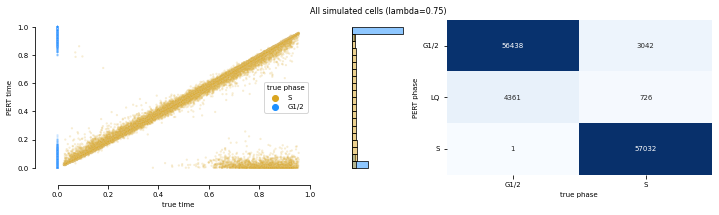

In [18]:
def plot_simulated_phase_accuracy(df_phase, axes, pt_size=5):
    plot_time_jointplot(df_phase, axes[0], axes[1], pt_size=pt_size)
    plot_confusion_matrix(df_phase, axes[2])

    # despine the scatterplot and histogram
    sns.despine(ax=axes[0], offset=despine_offset, trim=despine_trim)
    # sns.despine(ax=axes[1], offset=despine_offset, trim=despine_trim)

    # remove all the ticks, tick-labels, and spines from the histogram
    for spine in axes[1].spines.values():
        spine.set_visible(False)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    # put the title in the middle of the figure
    axes[1].set_title('All simulated cells (lambda=0.75)')

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False, gridspec_kw={'width_ratios': [1, 0.2, 1]}, tight_layout=True)
plot_simulated_phase_accuracy(df_phase, axes)
plt.show()

### Load and plot the simulated data and PERT results for simulated dataset P5.8

In [19]:
dataset = 'P5.8'
true_frac_col = 'true_cell_frac_rep'
model_rep_state = 'model_rep_state'
true_rep_state = 'true_rep'
model_cn_state = 'model_cn_state'
true_cn_state = 'true_G1_state'

cn_s_sim = pd.read_csv('scdna_replication_paper/analysis/simulation/{}/s_phase_cells_pyro_composite_inferred.tsv'.format(dataset), sep='\t')

# set chr column to category
cn_s_sim.chr = cn_s_sim.chr.astype(str)
cn_s_sim.chr = cn_s_sim.chr.astype('category')

# 1 is false positive, 0 is accurate, -1 is false negative
cn_s_sim['rt_state_diff'] = cn_s_sim[model_rep_state] - cn_s_sim[true_rep_state]

cn_s_sim.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,laks_is_s_phase,laks_is_s_phase_prob,laks_phase,assigned_clone_id,model_cn_state,model_rep_state,model_tau,model_u,model_rho,rt_state_diff
0,cell_S_0,1,2000000,2500000,1967,0.594508,0.997066,3.717724,4,2,...,True,0.94536,S,B,3,0.0,0.282036,222.90746,0.286288,-1.0
1,cell_S_0,1,4500000,5000000,621,0.481828,0.999002,1.862621,2,2,...,True,0.94536,S,B,2,0.0,0.282036,222.90746,0.627663,0.0
2,cell_S_0,1,6500000,7000000,776,0.489968,0.999179,2.247836,2,2,...,True,0.94536,S,B,2,0.0,0.282036,222.90746,0.263464,0.0
3,cell_S_0,1,7500000,8000000,625,0.488250,0.998566,1.823773,2,2,...,True,0.94536,S,B,2,0.0,0.282036,222.90746,0.340066,0.0
4,cell_S_0,1,8000000,8500000,1109,0.462702,0.998576,3.611801,4,2,...,True,0.94536,S,B,2,1.0,0.282036,222.90746,0.310921,0.0


In [23]:
def plot_true_vs_inferred_heatmaps(
    df,
    ax_sim_cn,
    ax_sim_rt,
    ax_inf_cn,
    ax_inf_rt,
    ax_clone_cn,
    ax_clone_rt,
    ax_time_cn,
    ax_time_rt,
    dataset='P5.8',
    true_frac_col='true_cell_frac_rep',
    model_rep_state='model_rep_state',
    true_rep_state='true_rep',
    model_cn_state='model_cn_state',
    true_cn_state='true_G1_state'
):
    """ 
    Plot heatmaps of true and inferred replication and copy states, as well as false positive/negative calls and input read depth.
    All rows of each heatmap are sorted by clone id and the true time in S-phase.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_col = 'clone_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # note which columns to sort by
    secondary_sort_column = true_frac_col

    # create a color map for the replication states and accuracies
    rt_cmap = get_rt_cmap()

    # compute accuracy of inferred rt_state values
    rep_accuracy = 1.0 - (sum(abs(df[true_rep_state] - df[model_rep_state])) / df.shape[0])

    # compute accuracy of inferred cn states
    cn_accuracy = sum(df[true_cn_state] == df[model_cn_state]) / df.shape[0]

    # top left: true CN state
    plot_data0 = plot_clustered_cell_cn_matrix(ax_sim_cn, df, true_cn_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, chrom_boundary_width=0.5)
    ax_sim_cn.set_title('True CN state')

    # top right: inferred CN state
    plot_data1 = plot_clustered_cell_cn_matrix(ax_inf_cn, df, model_cn_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, chrom_boundary_width=0.5)
    ax_inf_cn.set_title('PERT CN state (accuracy={})'.format(round(cn_accuracy, 3)))

    # bottom left: true replication state
    plot_data2 = plot_clustered_cell_cn_matrix(ax_sim_rt, df, true_rep_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, cmap=rt_cmap, chrom_boundary_width=0.5)
    ax_sim_rt.set_title('True replication state')

    # bottom right: inferred replication state
    plot_data3 = plot_clustered_cell_cn_matrix(ax_inf_rt, df, model_rep_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, cmap=rt_cmap, chrom_boundary_width=0.5)
    ax_inf_rt.set_title('PERT replication state (accuracy={})'.format(round(rep_accuracy, 3)))

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_sim_cn, ax_sim_rt, ax_inf_cn, ax_inf_rt]:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones for G1-phase cells
        cell_ids = plot_data0.columns.get_level_values(0).values
        cluster_ids0 = plot_data0.columns.get_level_values(1).values
        clone_cmap = get_clone_cmap()
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat0, color_map0 = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used0 = []
        for c in color_mat0:
            if c not in colors_used0:
                colors_used0.append(c)

        # match clone IDs to color pigments
        clones_to_colors0 = {}
        for i, key in enumerate(clone_dict.keys()):
            clones_to_colors0[key] = colors_used0[i]

        # get array of secondary_sort_column values that that match the cell_id order
        condensed_cn = df[['cell_id', secondary_sort_column]].drop_duplicates()
        secondary_array = []
        for cell in cell_ids:
            s = condensed_cn[condensed_cn['cell_id'] == cell][secondary_sort_column].values[0]
            secondary_array.append(s)

        # make color mat according to secondary array
        secondary_color_mat, secondary_to_colors = make_color_mat_float(secondary_array, 'Blues')

        # plot a color bar corresponding to clone ID
        plot_colorbar(ax_clone_cn, color_mat0)

        # plot a color bar corresponding to secondary_sort_column
        plot_colorbar(ax_time_cn, secondary_color_mat)

        # add the same color bars next to the heatmap on the bottom left corner
        plot_colorbar(ax_clone_rt, color_mat0)
        plot_colorbar(ax_time_rt, secondary_color_mat)

        # add y-axis labels to the ax_clone_cn and ax_clone_rt colors that specify the total number of S-phase cells
        num_cells = int(df.cell_id.nunique())
        ax_clone_cn.set_ylabel('{} S-phase cells'.format(num_cells))
        ax_clone_rt.set_ylabel('{} S-phase cells'.format(num_cells))

        # add x-axis ticklabels to the ax_clone_rt and ax_time_rt colors that these bars represent 'clone' and 'time' respectively
        ax_clone_rt.set_xticks([0.0])
        ax_clone_rt.set_xticklabels(['clone'], rotation=90)
        ax_time_rt.set_xticks([0.0])
        ax_time_rt.set_xticklabels(['time'], rotation=90)
            
    # add 'chromosome' x-axis label to the rt heatmaps
    ax_sim_rt.set_xlabel('chromosome')
    ax_inf_rt.set_xlabel('chromosome')


No handles with labels found to put in legend.


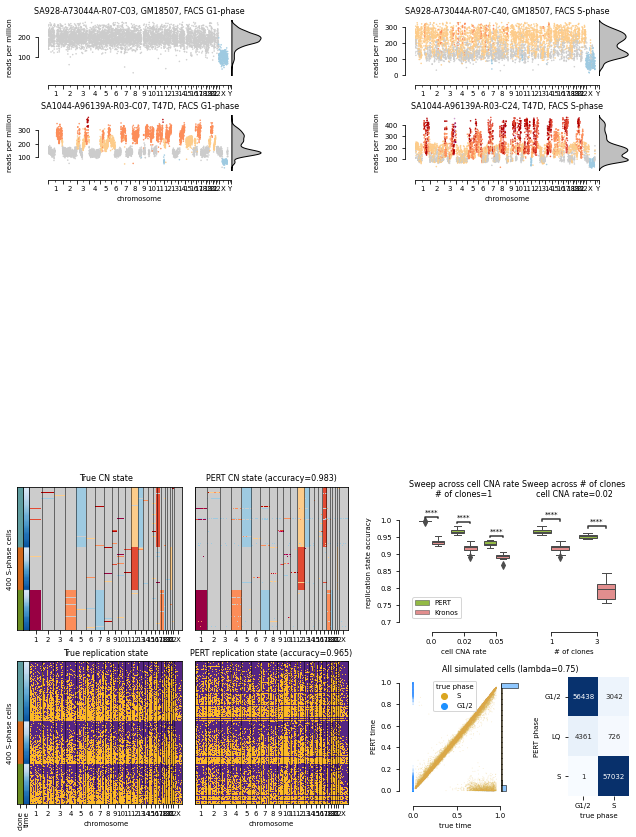

In [24]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 11/mult_factor))

# add an axis in the top left corner with size 0.25 x 0.1
ax0 = fig.add_axes([0.05, 0.92, 0.30, 0.07])
# ax0.set_title('ax0')

# add a small second axis to the right of ax0 with the same height
ax1 = fig.add_axes([0.35, 0.92, 0.05, 0.07])
# ax1.set_title('ax1')

# add an axis below ax0 with the same width and height
ax2 = fig.add_axes([0.05, 0.8, 0.30, 0.07])
# ax2.set_title('ax2')
# add a small second axis to the right of ax2 with the same height
ax3 = fig.add_axes([0.35, 0.8, 0.05, 0.07])
# ax3.set_title('ax3')

# repeat the pattern of ax0 - ax3 but for the top right corner of the figure
ax4 = fig.add_axes([0.65, 0.92, 0.30, 0.07])
# ax4.set_title('ax4')
ax5 = fig.add_axes([0.95, 0.92, 0.05, 0.07])
# ax5.set_title('ax5')

ax6 = fig.add_axes([0.65, 0.8, 0.30, 0.07])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.95, 0.8, 0.05, 0.07])
# ax7.set_title('ax7')

# add four large axes in the bottom left corner of the figure for the CN and replication heatmaps
ax8 = fig.add_axes([0.02, 0.0, 0.25, 0.18])
# ax8.set_title('ax8')
ax9 = fig.add_axes([0.02, 0.22, 0.25, 0.18])
# ax9.set_title('ax9')
ax10 = fig.add_axes([0.29, 0.0, 0.25, 0.18])
# ax10.set_title('ax10')
ax11 = fig.add_axes([0.29, 0.22, 0.25, 0.18])
# ax11.set_title('ax11')

# add two barplot annotation columns to the left of the heatmaps
ax12 = fig.add_axes([0.01, 0.0, 0.01, 0.18])
# ax12.set_title('ax12')
ax13 = fig.add_axes([0.0, 0.0, 0.01, 0.18])
# ax13.set_title('ax13')
ax14 = fig.add_axes([0.01, 0.22, 0.01, 0.18])
# ax14.set_title('ax14')
ax15 = fig.add_axes([0.0, 0.22, 0.01, 0.18])
# ax15.set_title('ax15')

# put a 4 x 4 grid of axes in the bottom right corner of the figure
# the top row of this 4x4 grid will show replication state accuracy
ax16 = fig.add_axes([0.64, 0.23, 0.18, 0.15])
# ax16.set_title('ax16')
ax17 = fig.add_axes([0.82, 0.23, 0.18, 0.15])
# ax17.set_title('ax17')

# create a smaller axes for this subplot since it will be a scatterplot + a histogram to the right
ax18 = fig.add_axes([0.64, 0.01, 0.15, 0.15])
# ax18.set_title('ax18')
ax19 = fig.add_axes([0.79, 0.01, 0.03, 0.15])
# ax19.set_title('ax19')

ax20 = fig.add_axes([0.9, 0.01, 0.1, 0.15])
# ax20.set_title('ax20')


# plot the example flow sorted cells
plot_cell_cn_profile_with_density(cn_gm_g1, ax0, ax1, title='{}, GM18507, FACS G1-phase'.format(cell_gm_g1), pt_size=0.3, xlabel=None)
plot_cell_cn_profile_with_density(cn_t_g1, ax2, ax3, title='{}, T47D, FACS G1-phase'.format(cell_t_g1), pt_size=0.3)
plot_cell_cn_profile_with_density(cn_gm_s, ax4, ax5, title='{}, GM18507, FACS S-phase'.format(cell_gm_s), pt_size=0.3, xlabel=None)
plot_cell_cn_profile_with_density(cn_t_s, ax6, ax7, title='{}, T47D, FACS S-phase'.format(cell_t_s), pt_size=0.3)

# plot the replication state accuracy vs cell cna rate and number of clones
plot_simulated_rep_accuracies(df_acc, [ax16, ax17])

# plot the phase accuracy jointplot and confusion matrix
plot_simulated_phase_accuracy(df_phase, [ax18, ax19, ax20], pt_size=1)

# plot the true vs pert inferred copy number and scRT heatmaps
plot_true_vs_inferred_heatmaps(
    cn_s_sim,
    ax9,
    ax8,
    ax11,
    ax10,
    ax15,
    ax13,
    ax14,
    ax12
)

fig.savefig('scdna_replication_paper/plots/simulation/main_figure_1.pdf', bbox_inches='tight', dpi=300)

plt.show()